In [1]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Importing & Parsing the csv

In [3]:

path_to_file='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_data.csv'
path_to_events='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_event.csv'
path_to_montage_glob='/media/venkatesh/venky/IMT-Study/2020/Stage/NDARNZ792HBN/EEG/preprocessed/csv_format/GSN_HydroCel_129.sfp'
path_to_montage_ses='/media/venkatesh/venky/IMT-Study/2020/Stage/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_chanlocs.csv'
fs=500
chans_glob=mne.channels.read_montage(path_to_montage_glob)
# channels to exclude because noisy (Nentwich paper)
ch_list=[]

def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage=path_to_montage_glob):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data=np.loadtxt(path_to_file,delimiter=',')
    chans=pd.read_csv(path_to_montage_ses,sep=',',header=None)
    ch_names=list(chans.values[1:,0])

    types=['eeg']*len(ch_names)
    info=mne.create_info(ch_names,sfreq=fs,ch_types=types)
    raw=mne.io.RawArray(data, info)

    # set standard montage
    if montage:
        raw.set_montage(montage)

    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep=r'\s*,\s*', header=None, engine='python')
        values = raw_events[0].to_list()
    
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']

        samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype=int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype=int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis=0).astype('int')
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep=mne.pick_channels(raw.ch_names,include=raw.ch_names,exclude=ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    return raw

raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage=path_to_montage_glob)


Creating RawArray with float64 data, n_channels=111, n_times=176386
    Range : 0 ... 176385 =      0.000 ...   352.770 secs
Ready.


# Sanity check = events

In [11]:
epoched = mne.Epochs(raw,events)
epoched

13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


<ipython-input-11-8bc640649ec4>:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoched = mne.Epochs(raw,events)


<Epochs  |   13 events (good & bad), -0.2 - 0.5 sec, baseline [None, 0], ~288 kB, data not loaded,
 '1': 1
 '20': 6
 '30': 5
 '90': 1>

# Plotting the Electrodes

In [19]:
from mpl_toolkits.mplot3d import axes3d

# kind = kinda standard which has 3D coordinates for 128 electrodes and 3 default things
montage_plot = mne.channels.make_standard_montage(kind= "GSN-HydroCel-129")  
# Note: By default, the 3d plots displayed here does not show the 3rd axis, thus require a
# a package called qt, can be called with %matplotlib qt
%matplotlib qt

fig = montage_plot.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)


Traceback (most recent call last):
  File "/home/venkatesh/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/mne/viz/utils.py", line 1668, in _close_event
    if getattr(fig, 'lasso') is not None:
AttributeError: 'Figure' object has no attribute 'lasso'


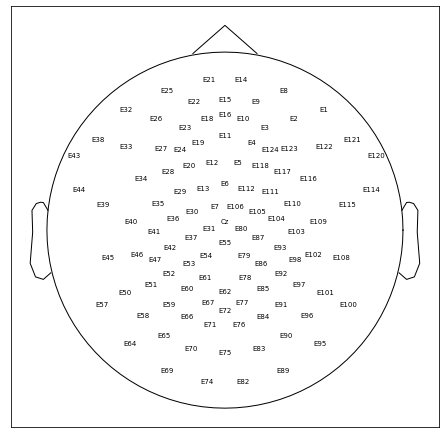

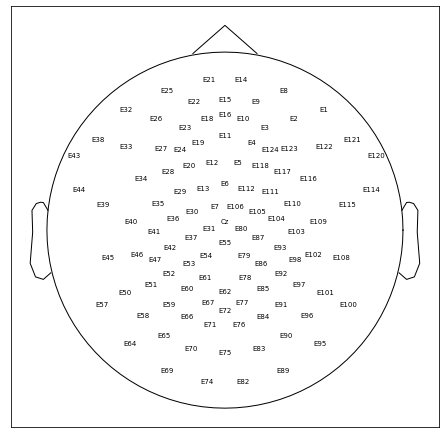

In [20]:
%matplotlib inline
mne.channels.make_eeg_layout(raw.info).plot()

# Plotting Signals

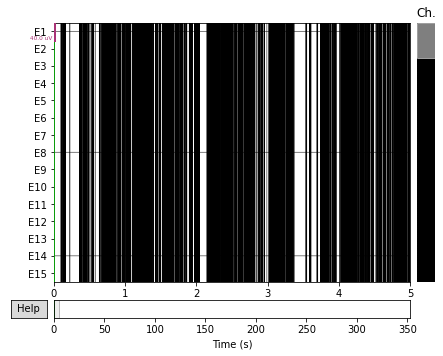

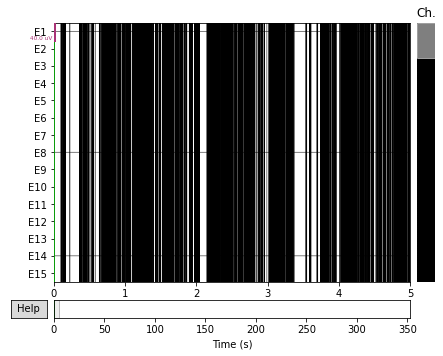

In [27]:
# Signal in Time domain
mne.viz.plot_raw(raw,n_channels=15,duration =5) #could be due to scaling..

Effective window size : 4.096 (s)


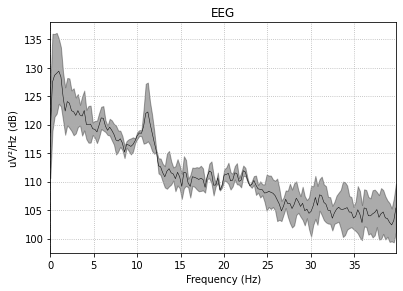

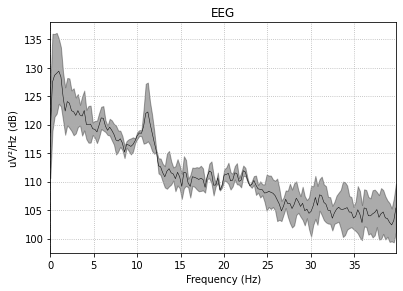

In [24]:
raw.plot_psd(tmax=70,fmax=40,picks=['E4','E36','E49','E58','E96','E100'],area_mode='std',average=True)

Effective window size : 4.096 (s)


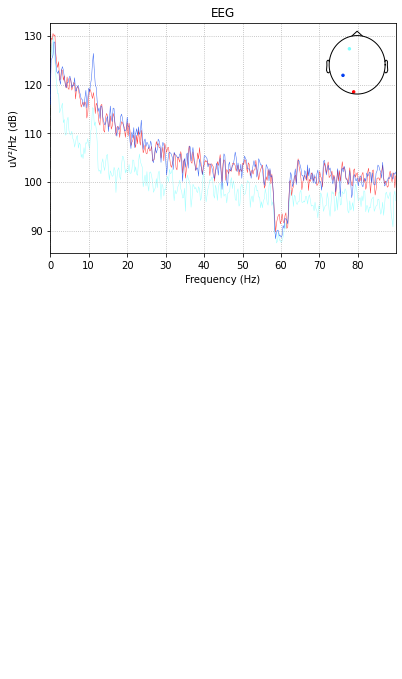

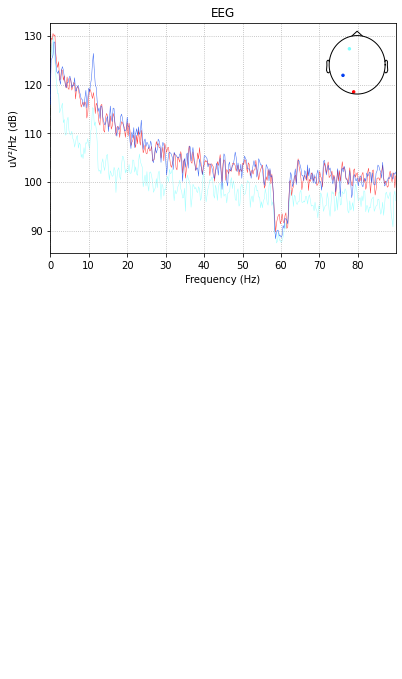

In [25]:
mne.viz.plot_raw_psd(raw,tmax=40,fmax=90,picks=['E74','E51','E23'])

Using up to 1763 segments
Number of samples used : 176300
[done]
Computing data rank from covariance with rank=None
    Using tolerance 0.57 (2.2e-16 eps * 111 dim * 2.3e+13  max singular value)
    Estimated rank (eeg): 105
    EEG: rank 105 computed from 111 data channels with 0 projectors


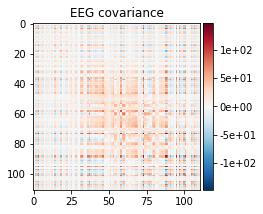

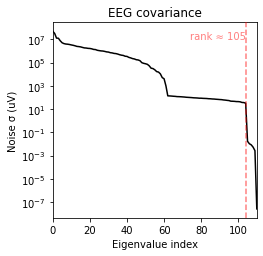

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [10]:
# Plotting covariance
mne.viz.plot_cov(mne.compute_raw_covariance(raw),raw.info) 